## Flood Prediction in Malawi:
On 14 March 2019, tropical Cyclone Idai made landfall at the port of Beira, Mozambique, before moving across the region. Millions of people in Malawi, Mozambique and Zimbabwe have been affected by what is the worst natural disaster to hit southern Africa in at least two decades.

In recent decades, countries across Africa have experienced an increase in the frequency and severity of floods. Malawi has been hit with major floods in 2015 and again in 2019. In fact, between 1946 and 2013, floods accounted for 48% of major disasters in Malawi. The Lower Shire Valley in southern Malawi, bordering Mozambique, composed of Chikwawa and Nsanje Districts is the area most prone to flooding.

The objective of this challenge is to build a machine learning model that helps predict the location and extent of floods in southern Malawi.

This competition is sponsored by [Arm](https://www.arm.com/) and [UNICEF](https://www.unicef.org/) as part of the [2030Vision](https://www.2030vision.com/) initiative.

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import catboost

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Dropout,Input,Dense,BatchNormalization,Reshape,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,AveragePooling2D,ConvLSTM2D, Concatenate,MaxPool2D,GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K

import utils
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

In [147]:
# Paths to data
data_path = './raw_data/Train.csv'
submission_path = './raw_data/SampleSubmission.csv'

## Data Cleaning and Analysis

In [148]:
# The datasets
dataset = utils.read_data(data_path)
submission = utils.read_data(submission_path)

In [149]:
dataset.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,16416,16417,16418,16419,16420,16421,16422,16423,16424,16425,16426,16427,16428,16429,16430,16431,16432,16433,16434,16435,16436,16437,16438,16439,16440,16441,16442,16443,16444,16445,16446,16447,16448,16449,16450,16451,16452,16453,16454,16455,16456,16457,16458,16459,16460,16461,16462,16463,16464,16465
X,34.26,34.26,34.26,34.26,34.26,34.26,34.26,34.26,34.26,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.27,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.28,34.29,34.29,34.29,34.29,34.29,34.29,34.29,34.29,34.29,34.29,34.29,34.29,...,35.84,35.84,35.84,35.84,35.84,35.84,35.84,35.84,35.84,35.84,35.84,35.84,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.85,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86,35.86
Y,-15.91,-15.9,-15.89,-15.88,-15.87,-15.86,-15.85,-15.84,-15.83,-15.92,-15.91,-15.9,-15.89,-15.88,-15.87,-15.86,-15.85,-15.84,-15.83,-15.82,-15.81,-15.8,-15.79,-15.92,-15.91,-15.9,-15.89,-15.88,-15.87,-15.86,-15.85,-15.84,-15.83,-15.82,-15.81,-15.8,-15.79,-15.78,-15.93,-15.92,-15.91,-15.9,-15.89,-15.88,-15.87,-15.86,-15.85,-15.84,-15.83,-15.82,...,-15.44,-15.43,-15.42,-15.41,-15.4,-15.39,-15.38,-15.37,-15.36,-15.35,-15.34,-15.33,-15.62,-15.61,-15.6,-15.59,-15.58,-15.57,-15.56,-15.55,-15.54,-15.53,-15.52,-15.51,-15.5,-15.49,-15.48,-15.47,-15.46,-15.45,-15.44,-15.43,-15.42,-15.41,-15.4,-15.39,-15.38,-15.37,-15.36,-15.5,-15.49,-15.48,-15.47,-15.46,-15.45,-15.44,-15.43,-15.42,-15.41,-15.4
target_2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0697336,0.156173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0958696,0.581675,0.281664,0,0,0,0,0,0,0,1,1,0.8715,0,0,0,0,0,0,0,0,0.531197,1,1,0.996203,0.651222,0.25647,0,0,0,0,0.322607,0.585838,0.361735,0.058265,0,0,0.888695,1,0.966923,0.622703,0.0572244,0,0,0,0,0,0
elevation,887.764,743.404,565.728,443.393,437.443,405.632,389.261,383.123,382.92,826.058,782.354,775.974,524.29,424.104,408.447,394.484,372.841,368.799,360.846,393.253,403.808,399.942,419.709,699.74,744.003,652.116,456.148,406.71,396.281,388.507,368.409,347.146,350.832,368.277,372.852,407.771,488.856,487.659,461.149,499.848,492.456,441.08,395.32,405.696,394.709,384.222,366.075,340.831,341.532,351.234,...,623.446,625.29,626.79,625.514,623.92,624.186,623.196,623.047,623.242,623.484,623.201,623.002,634.464,635.153,636.94,642.679,654.309,722.309,710.158,646.392,637.417,629.396,629.37,626.096,624.08,624.15,624.767,624.433,624.578,625.693,627.157,627.914,629.525,626.379,625.218,624.075,623.293,623.137,623,624.829,624.21,624.426,625.041,627.22,631.86,635.675,632.599,632.45,629.273,626.165
precip 2014-11-16 - 2014-11-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,0,0,0,0,0,0,0,0,0,0,0,0,1.56605,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,1.56108,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566,16.9566
precip 2014-11-23 - 2014-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,3.47912,6.03523,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,6.02711,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555,31.1555
precip 2014-11-30 - 2014-12-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [150]:
# Train info
utils.analyze_data(dataset)

Null value check:
 X                                 0
Y                                 0
target_2015                       0
elevation                         0
precip 2014-11-16 - 2014-11-23    0
precip 2014-11-23 - 2014-11-30    0
precip 2014-11-30 - 2014-12-07    0
precip 2014-12-07 - 2014-12-14    0
precip 2014-12-14 - 2014-12-21    0
precip 2014-12-21 - 2014-12-28    0
precip 2014-12-28 - 2015-01-04    0
precip 2015-01-04 - 2015-01-11    0
precip 2015-01-11 - 2015-01-18    0
precip 2015-01-18 - 2015-01-25    0
precip 2015-01-25 - 2015-02-01    0
precip 2015-02-01 - 2015-02-08    0
precip 2015-02-08 - 2015-02-15    0
precip 2015-02-15 - 2015-02-22    0
precip 2015-02-22 - 2015-03-01    0
precip 2015-03-01 - 2015-03-08    0
precip 2015-03-08 - 2015-03-15    0
precip 2019-01-20 - 2019-01-27    0
precip 2019-01-27 - 2019-02-03    0
precip 2019-02-03 - 2019-02-10    0
precip 2019-02-10 - 2019-02-17    0
precip 2019-02-17 - 2019-02-24    0
precip 2019-02-24 - 2019-03-03    0
precip 20

,count,mean,std,min,25%,50%,75%,max
X,16466.0,35.077656,0.392395,34.260000,34.760000,35.050000,35.390000,35.860000
Y,16466.0,-15.813802,0.359789,-16.640000,-16.070000,-15.800000,-15.520000,-15.210000
target_2015,16466.0,0.076609,0.228734,0.000000,0.000000,0.000000,0.000000,1.000000
elevation,16466.0,592.848206,354.790357,45.541444,329.063852,623.000000,751.434813,2803.303645
precip 2014-11-16 - 2014-11-23,16466.0,1.610760,4.225461,0.000000,0.000000,0.000000,1.261848,19.354969
precip 2014-11-23 - 2014-11-30,16466.0,2.502058,8.631846,0.000000,0.000000,0.000000,0.000000,41.023858
precip 2014-11-30 - 2014-12-07,16466.0,1.162076,4.396676,0.000000,0.000000,0.000000,0.000000,22.020803
precip 2014-12-07 - 2014-12-14,16466.0,8.270610,4.263375,1.411452,5.548440,7.941822,10.887235,18.870675
precip 2014-12-14 - 2014-12-21,16466.0,8.892459,3.760052,3.580342,5.905440,8.618390,10.960668,23.044340
precip 2014-12-21 - 2014-12-28,16466.0,9.572821,4.523767,1.254098,6.179885,8.786780,12.670775,21.757828


In [151]:
train_set = utils.split_data(dataset, train=True, test=False)
test_set = utils.split_data(dataset, train=False, test=True)

In [152]:
# Outlier handling
# 75% of observations have an elevation of 751.43 yet
# the max elevation is over thrice this elevation; signalling outliers.
# Since places of higher elevation are less prone to flooding,
# We need to reduce their representation in the dataset
#remove = train_set[(train_set.elevation > 2000) & (train_set.target_2015 < 0.4)]
#print(len(remove.index))
#train_set.drop(remove.index, inplace=True)

Text(0, 0.5, 'Frequency')

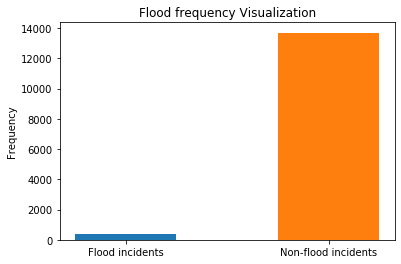

In [153]:
#Visualizing flood extent for 2015
x = train_set['target_2015'].value_counts()[1]
y = train_set['target_2015'].value_counts()[0]

fig, ax = plt.subplots()
ax.set_title("Flood frequency Visualization")
ax.bar('Flood incidents', x, width=0.5)
ax.bar('Non-flood incidents', y, width=0.5)
plt.ylabel('Frequency')

In [154]:
'''Computing total weekly precipitation and precipitation 2 weeks before flooding.'''

train_precip = train_set.columns[4:21]

#train_set['week_1'] = train_set[train_precip[7]]
#train_set['week_2'] = train_set[train_precip[8]]
train_set['total_precip'] = train_set[train_precip].sum(axis=1)

'''Computing for the test set'''
precip = test_set.columns[:17]

#test_set['week_1'] = test_set[precip[6]]
#test_set['week_2'] = test_set[precip[7]]
test_set['total_precip'] = test_set[precip].sum(axis=1)

test_set.head(3)

,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,X,Y,elevation,LC_Type1_mode,Square_ID,week_2,total_precip
0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,34.26,-15.91,887.764222,9,4e3c3896-14ce-11ea-bce5-f49634744a41,18.264692,182.233292
1,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,34.26,-15.90,743.403912,9,4e3c3897-14ce-11ea-bce5-f49634744a41,18.264692,182.233292
2,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,34.26,-15.89,565.728343,9,4e3c3898-14ce-11ea-bce5-f49634744a41,18.264692,182.233292


In [155]:
# one-hot encode lC_type
#train_set = pd.concat([train_set, pd.get_dummies(train_set['LC_Type1_mode'], prefix='lc')], axis=1)
#test_set = pd.concat([test_set, pd.get_dummies(test_set['LC_Type1_mode'], prefix='lc')], axis=1)

# Remove original LC_Type feature column
#train_set.drop(['LC_Type1_mode'], axis=1, inplace=True)
#test_set.drop(['LC_Type1_mode'], axis=1, inplace=True)

In [156]:
# splitting dataset into train&test
target = train_set.pop('target_2015')

#Realigning the train&test sets
train_set, test_set = train_set.align(test_set, join='inner', axis=1)

In [157]:
# Feature engineering
train_set['bearing'] = np.arctan(train_set.Y/train_set.X)  # radians
test_set['bearing'] = np.arctan(test_set.Y/test_set.X)  # radians

# Each rectangle is centered 0.01 degrees from each side(~1.11km ::= 1.11e3 metres)
# Therefore the length and width of @rectangle is ~1.11km*2 (1.11km-left + 1.11km-right)
train_set['area'] = ((1.11e3*2) ** 2 )
test_set['area'] = ((1.11e3*2) ** 2)

train_set['Volume'] = train_set.elevation * train_set.area # V=l*w*h (area*height)
test_set['Volume'] = test_set.elevation * test_set.area

train_set['slope'] = ((train_set.Y + 0.5) - (train_set.Y - 0.5))/((train_set.X + 0.5) - (train_set.X - 0.5)) # gradient/slope calc
test_set['slope'] = ((test_set.Y + 0.5) - (test_set.Y - 0.5))/((test_set.X + 0.5) - (test_set.X - 0.5)) # gradient

train_set['distance'] = np.sqrt(np.square(train_set.elevation) + train_set.area) # Hypoteneuse of the right-angeled triangle
test_set['distance'] = np.sqrt(np.square(test_set.elevation) + test_set.area)

In [158]:
encoder = LabelEncoder()
#train_set['loc_hash'] = encoder.fit_transform(train_set.loc_hash)
#test_set['loc_hash'] = encoder.transform(test_set.loc_hash)

In [159]:
train_set.head(3)

,X,Y,elevation,LC_Type1_mode,Square_ID,week_2,total_precip,bearing,area,Volume,slope,distance
0,34.26,-15.91,887.764222,9,4e3c3896-14ce-11ea-bce5-f49634744a41,30.449468,252.55998,-0.434756,4928400.0,4.375257e+09,1.0,2390.925619
1,34.26,-15.90,743.403912,9,4e3c3897-14ce-11ea-bce5-f49634744a41,30.449468,252.55998,-0.434516,4928400.0,3.663792e+09,1.0,2341.164107
2,34.26,-15.89,565.728343,9,4e3c3898-14ce-11ea-bce5-f49634744a41,30.449468,252.55998,-0.434276,4928400.0,2.788136e+09,1.0,2290.949270


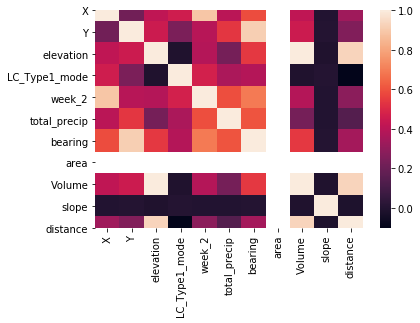

In [160]:
corr = train_set.corr()
sns.heatmap(corr)

## Modelling and Evaluation

In [161]:
Id = test_set['Square_ID']
train_set.drop(['Square_ID'], axis=1, inplace=True)
test_set.drop(['Square_ID'], axis=1, inplace=True)

In [162]:
# splitting the train_set to derive a validation set
X = train_set.drop(['area'], axis=1)
test_set = test_set.drop(['area'], axis=1)

#X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.2, random_state=42)

In [105]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean((K.square(y_pred - y_true))))

In [58]:
# NeuralNet
def get_model(lstm_shape):
    Lstm_Input = Input(lstm_shape)
    Norm_1 = BatchNormalization()(Lstm_Input)
    R_1 = Reshape((-1, 8))(Norm_1)
    L_1 = LSTM(128)(R_1)
    
    main = Dense(64, activation= 'relu')(main)
    main = Dense(32, activation= 'relu')(main)
    #main = Dense(16, activation= 'relu')(main)
    out = Dense(1, activation= 'sigmoid')(main)
    
    model = Model(Lstm_Input,out)
    model.summary()
    
    return model

model = get_model((8))

early_stopping = EarlyStopping(monitor='val_rmse', patience=3)

# Gradually reduce the learning rate if validation loss doesn't improve after 5 steps
learning_rate_decay = ReduceLROnPlateau(monitor='val_rmse',
                                        patience=3, 
                                        verbose=1, 
                                        factor=0.2, 
                                        min_lr=0.00001
                                        )
model.compile(loss='mse', optimizer=RMSprop(), metrics=[rmse])


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8)                 32        
_________________________________________________________________
reshape_5 (Reshape)          (None, None, 8)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               271360    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080

In [59]:
# NN training
scores = []
kfold = KFold(n_splits=4, shuffle=False)
for train, val in kfold.split(X, target):
    X_train, y_train = X.iloc[train], target.iloc[train]
    X_val, y_val = X.iloc[val], target.iloc[val]
    
    history = model.fit(X_train, y_train, 
                        epochs=12,
                        verbose=1,
                        batch_size=8,
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, learning_rate_decay]
                       )
    
    root_mse = np.mean(history.history['val_rmse'])
    scores.append(root_mse)

print("Average score in 5-fold CV:", np.mean(scores))


W0514 20:09:10.753238 139755200800576 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 12349 samples, validate on 4117 samples
Epoch 1/12
12349/12349 [==============================] - 22s 2ms/sample - loss: 0.0541 - rmse: 0.2074 - val_loss: 0.0053 - val_rmse: 0.0323
Epoch 2/12
12349/12349 [==============================] - 20s 2ms/sample - loss: 0.0506 - rmse: 0.1999 - val_loss: 0.0053 - val_rmse: 0.0336
Epoch 3/12
12349/12349 [==============================] - 15s 1ms/sample - loss: 0.0511 - rmse: 0.2014 - val_loss: 0.0053 - val_rmse: 0.0413
Epoch 4/12
12349/12349 [==============================] - 12s 985us/sample - loss: 0.0525 - rmse: 0.2034 - val_loss: 0.0053 - val_rmse: 0.0429
Epoch 5/12
12349/12349 [==============================] - 12s 940us/sample - loss: 0.0498 - rmse: 0.1980 - val_loss: 0.0052 - val_rmse: 0.0346
Epoch 6/12
12296/12349 [============================>.] - ETA: 0s - loss: 0.0502 - rmse: 0.1984
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
12349/12349 [==============================] - 11s 931us/sample -

W0514 20:10:44.455869 139755200800576 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 12349 samples, validate on 4117 samples
Epoch 1/12
12349/12349 [==============================] - 13s 1ms/sample - loss: 0.0337 - rmse: 0.1509 - val_loss: 0.0469 - val_rmse: 0.1970
Epoch 2/12
12349/12349 [==============================] - 20s 2ms/sample - loss: 0.0324 - rmse: 0.1474 - val_loss: 0.0477 - val_rmse: 0.1990
Epoch 3/12
12349/12349 [==============================] - 20s 2ms/sample - loss: 0.0328 - rmse: 0.1504 - val_loss: 0.0521 - val_rmse: 0.2075
Epoch 4/12
12349/12349 [==============================] - 20s 2ms/sample - loss: 0.0323 - rmse: 0.1475 - val_loss: 0.0527 - val_rmse: 0.2102
Epoch 5/12
12349/12349 [==============================] - 20s 2ms/sample - loss: 0.0324 - rmse: 0.1478 - val_loss: 0.0539 - val_rmse: 0.2092
Epoch 6/12
12344/12349 [============================>.] - ETA: 0s - loss: 0.0319 - rmse: 0.1475
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
12349/12349 [==============================] - 20s 2ms/sample - loss:

W0514 20:12:38.525778 139755200800576 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 12350 samples, validate on 4116 samples
Epoch 1/12
12350/12350 [==============================] - 19s 2ms/sample - loss: 0.0458 - rmse: 0.1840 - val_loss: 0.0178 - val_rmse: 0.1054
Epoch 2/12
12350/12350 [==============================] - 19s 2ms/sample - loss: 0.0440 - rmse: 0.1830 - val_loss: 0.0183 - val_rmse: 0.1068
Epoch 3/12
12350/12350 [==============================] - 19s 2ms/sample - loss: 0.0447 - rmse: 0.1830 - val_loss: 0.0196 - val_rmse: 0.1109
Epoch 4/12
12350/12350 [==============================] - 19s 2ms/sample - loss: 0.0438 - rmse: 0.1813 - val_loss: 0.0187 - val_rmse: 0.1074
Epoch 5/12
12350/12350 [==============================] - 22s 2ms/sample - loss: 0.0442 - rmse: 0.1813 - val_loss: 0.0185 - val_rmse: 0.1076
Epoch 6/12
12336/12350 [============================>.] - ETA: 0s - loss: 0.0439 - rmse: 0.1824
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1e-05.
12350/12350 [==============================] - 20s 2ms/sample - loss: 0.0439 - rmse: 0

W0514 20:14:37.323002 139755200800576 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 12350 samples, validate on 4116 samples
Epoch 1/12
12350/12350 [==============================] - 22s 2ms/sample - loss: 0.0317 - rmse: 0.1491 - val_loss: 0.0706 - val_rmse: 0.2312
Epoch 2/12
12350/12350 [==============================] - 20s 2ms/sample - loss: 0.0296 - rmse: 0.1413 - val_loss: 0.0726 - val_rmse: 0.2305
Epoch 3/12
12350/12350 [==============================] - 13s 1ms/sample - loss: 0.0290 - rmse: 0.1386 - val_loss: 0.0752 - val_rmse: 0.2327
Epoch 4/12
12350/12350 [==============================] - 13s 1ms/sample - loss: 0.0285 - rmse: 0.1353 - val_loss: 0.0763 - val_rmse: 0.2342
Epoch 5/12
12350/12350 [==============================] - 12s 1ms/sample - loss: 0.0292 - rmse: 0.1375 - val_loss: 0.0788 - val_rmse: 0.2360
Epoch 6/12
12350/12350 [==============================] - 13s 1ms/sample - loss: 0.0282 - rmse: 0.1349 - val_loss: 0.0794 - val_rmse: 0.2370
Epoch 7/12
12350/12350 [==============================] - 12s 1ms/sample - loss: 0.0275 - rmse: 0.1313 - 

In [26]:
# modelling and validation
kf = KFold(n_splits=4, shuffle=False)

scores = []
for train, val in kf.split(X, target):
    model = RandomForestRegressor(n_estimators=150, max_depth=5, n_jobs=-1, max_features='sqrt',
                                random_state=77)
    X_train, y_train = X.iloc[train], target.iloc[train]
    X_val, y_val =X.iloc[val], target.iloc[val]
    
    model.fit(X_train, y_train)
    root_mse = utils.rmse(y_val, model.predict(X_val))
    scores.append(root_mse)
    print(root_mse)

print("Average score in 5-fold CV:", np.mean(scores))

0.0742528340192861
0.24008744357496026
0.09659608843860693
0.29817832238433645
Average score in 5-fold CV: 0.17727867210429743


CPU times: user 3.52 s, sys: 2.67 ms, total: 3.52 s
Wall time: 3.58 s


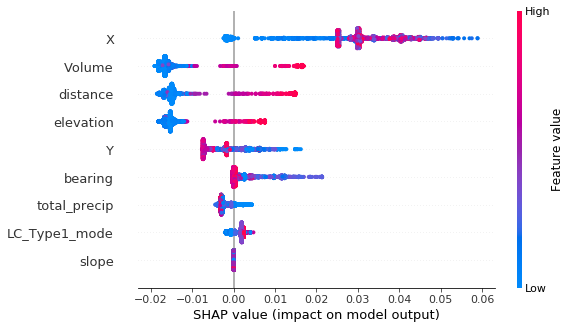

In [31]:
%time shap_values = shap.TreeExplainer(model).shap_values(X_val)
shap.summary_plot(shap_values, X_val)

In [169]:
# Catboost
kfold = KFold(n_splits=4, shuffle=False)

score = []
for train, val in kfold.split(X, target):
    # Catboost
    catboost_model = catboost.CatBoostRegressor(iterations=550,
                                          learning_rate=0.035,
                                          depth=5,
                                          loss_function='RMSE',
                                          random_state=77
                                          )
    catboost_model.fit(X.iloc[train], target.iloc[train])
    root_mse = utils.rmse(target.iloc[val], catboost_model.predict(X.iloc[val]))
    score.append(root_mse)
    print(root_mse)

print("Average score in 5-fold CV:", np.mean(score))

0:	learn: 0.2510971	total: 5ms	remaining: 2.75s
1:	learn: 0.2449621	total: 8.1ms	remaining: 2.22s
2:	learn: 0.2393897	total: 11.2ms	remaining: 2.04s
3:	learn: 0.2343448	total: 14.1ms	remaining: 1.92s
4:	learn: 0.2294004	total: 16.9ms	remaining: 1.84s
5:	learn: 0.2250206	total: 20.3ms	remaining: 1.84s
6:	learn: 0.2209381	total: 23.2ms	remaining: 1.79s
7:	learn: 0.2168988	total: 26.2ms	remaining: 1.78s
8:	learn: 0.2129732	total: 29.1ms	remaining: 1.75s
9:	learn: 0.2098497	total: 31.8ms	remaining: 1.72s
10:	learn: 0.2070211	total: 34.5ms	remaining: 1.69s
11:	learn: 0.2041488	total: 37.5ms	remaining: 1.68s
12:	learn: 0.2009261	total: 40.4ms	remaining: 1.67s
13:	learn: 0.1980048	total: 43.2ms	remaining: 1.65s
14:	learn: 0.1957630	total: 46ms	remaining: 1.64s
15:	learn: 0.1937461	total: 48.7ms	remaining: 1.62s
16:	learn: 0.1917083	total: 51.8ms	remaining: 1.62s
17:	learn: 0.1894212	total: 55.5ms	remaining: 1.64s
18:	learn: 0.1871030	total: 58.9ms	remaining: 1.65s
19:	learn: 0.1851040	total: 

163:	learn: 0.1296983	total: 791ms	remaining: 1.86s
164:	learn: 0.1296129	total: 801ms	remaining: 1.87s
165:	learn: 0.1293080	total: 805ms	remaining: 1.86s
166:	learn: 0.1291758	total: 812ms	remaining: 1.86s
167:	learn: 0.1290457	total: 817ms	remaining: 1.86s
168:	learn: 0.1288880	total: 823ms	remaining: 1.85s
169:	learn: 0.1288092	total: 831ms	remaining: 1.86s
170:	learn: 0.1286605	total: 835ms	remaining: 1.85s
171:	learn: 0.1285101	total: 838ms	remaining: 1.84s
172:	learn: 0.1284330	total: 846ms	remaining: 1.84s
173:	learn: 0.1283583	total: 850ms	remaining: 1.84s
174:	learn: 0.1283116	total: 853ms	remaining: 1.83s
175:	learn: 0.1282104	total: 859ms	remaining: 1.82s
176:	learn: 0.1281460	total: 864ms	remaining: 1.82s
177:	learn: 0.1279665	total: 868ms	remaining: 1.81s
178:	learn: 0.1278642	total: 873ms	remaining: 1.81s
179:	learn: 0.1276664	total: 879ms	remaining: 1.81s
180:	learn: 0.1275935	total: 882ms	remaining: 1.8s
181:	learn: 0.1275327	total: 885ms	remaining: 1.79s
182:	learn: 0

330:	learn: 0.1131190	total: 1.77s	remaining: 1.18s
331:	learn: 0.1129707	total: 1.78s	remaining: 1.17s
332:	learn: 0.1128303	total: 1.78s	remaining: 1.16s
333:	learn: 0.1127899	total: 1.79s	remaining: 1.16s
334:	learn: 0.1127419	total: 1.79s	remaining: 1.15s
335:	learn: 0.1126976	total: 1.8s	remaining: 1.15s
336:	learn: 0.1126460	total: 1.8s	remaining: 1.14s
337:	learn: 0.1125658	total: 1.8s	remaining: 1.13s
338:	learn: 0.1125331	total: 1.81s	remaining: 1.13s
339:	learn: 0.1125115	total: 1.81s	remaining: 1.12s
340:	learn: 0.1124690	total: 1.82s	remaining: 1.12s
341:	learn: 0.1124472	total: 1.83s	remaining: 1.11s
342:	learn: 0.1123533	total: 1.83s	remaining: 1.1s
343:	learn: 0.1122809	total: 1.83s	remaining: 1.1s
344:	learn: 0.1122572	total: 1.84s	remaining: 1.09s
345:	learn: 0.1122245	total: 1.84s	remaining: 1.08s
346:	learn: 0.1121705	total: 1.84s	remaining: 1.08s
347:	learn: 0.1121010	total: 1.85s	remaining: 1.07s
348:	learn: 0.1120141	total: 1.85s	remaining: 1.06s
349:	learn: 0.111

497:	learn: 0.1051267	total: 2.56s	remaining: 268ms
498:	learn: 0.1050928	total: 2.57s	remaining: 263ms
499:	learn: 0.1050552	total: 2.58s	remaining: 258ms
500:	learn: 0.1049962	total: 2.59s	remaining: 253ms
501:	learn: 0.1048843	total: 2.59s	remaining: 248ms
502:	learn: 0.1048292	total: 2.59s	remaining: 242ms
503:	learn: 0.1048016	total: 2.6s	remaining: 237ms
504:	learn: 0.1047704	total: 2.6s	remaining: 232ms
505:	learn: 0.1047465	total: 2.61s	remaining: 227ms
506:	learn: 0.1047081	total: 2.61s	remaining: 222ms
507:	learn: 0.1046802	total: 2.62s	remaining: 216ms
508:	learn: 0.1045776	total: 2.62s	remaining: 211ms
509:	learn: 0.1045546	total: 2.63s	remaining: 206ms
510:	learn: 0.1045264	total: 2.63s	remaining: 201ms
511:	learn: 0.1045010	total: 2.64s	remaining: 196ms
512:	learn: 0.1044738	total: 2.64s	remaining: 190ms
513:	learn: 0.1044409	total: 2.65s	remaining: 185ms
514:	learn: 0.1044206	total: 2.65s	remaining: 180ms
515:	learn: 0.1043399	total: 2.65s	remaining: 175ms
516:	learn: 0.

159:	learn: 0.1124449	total: 716ms	remaining: 1.75s
160:	learn: 0.1123784	total: 722ms	remaining: 1.75s
161:	learn: 0.1123439	total: 726ms	remaining: 1.74s
162:	learn: 0.1122919	total: 731ms	remaining: 1.73s
163:	learn: 0.1121724	total: 735ms	remaining: 1.73s
164:	learn: 0.1119334	total: 748ms	remaining: 1.74s
165:	learn: 0.1118894	total: 773ms	remaining: 1.79s
166:	learn: 0.1118594	total: 783ms	remaining: 1.8s
167:	learn: 0.1118052	total: 790ms	remaining: 1.79s
168:	learn: 0.1117341	total: 795ms	remaining: 1.79s
169:	learn: 0.1117020	total: 808ms	remaining: 1.81s
170:	learn: 0.1116621	total: 816ms	remaining: 1.81s
171:	learn: 0.1116024	total: 827ms	remaining: 1.82s
172:	learn: 0.1115512	total: 832ms	remaining: 1.81s
173:	learn: 0.1114849	total: 837ms	remaining: 1.81s
174:	learn: 0.1114596	total: 842ms	remaining: 1.8s
175:	learn: 0.1112801	total: 848ms	remaining: 1.8s
176:	learn: 0.1111300	total: 853ms	remaining: 1.8s
177:	learn: 0.1109816	total: 857ms	remaining: 1.79s
178:	learn: 0.11

334:	learn: 0.0997626	total: 1.7s	remaining: 1.09s
335:	learn: 0.0997435	total: 1.71s	remaining: 1.09s
336:	learn: 0.0997044	total: 1.71s	remaining: 1.08s
337:	learn: 0.0996454	total: 1.72s	remaining: 1.08s
338:	learn: 0.0995948	total: 1.72s	remaining: 1.07s
339:	learn: 0.0995080	total: 1.73s	remaining: 1.07s
340:	learn: 0.0994464	total: 1.74s	remaining: 1.06s
341:	learn: 0.0993801	total: 1.74s	remaining: 1.06s
342:	learn: 0.0992803	total: 1.74s	remaining: 1.05s
343:	learn: 0.0992612	total: 1.74s	remaining: 1.04s
344:	learn: 0.0992341	total: 1.75s	remaining: 1.04s
345:	learn: 0.0992062	total: 1.76s	remaining: 1.03s
346:	learn: 0.0991777	total: 1.76s	remaining: 1.03s
347:	learn: 0.0991513	total: 1.76s	remaining: 1.02s
348:	learn: 0.0991182	total: 1.77s	remaining: 1.02s
349:	learn: 0.0991012	total: 1.77s	remaining: 1.01s
350:	learn: 0.0990324	total: 1.78s	remaining: 1.01s
351:	learn: 0.0989957	total: 1.78s	remaining: 1s
352:	learn: 0.0989642	total: 1.78s	remaining: 996ms
353:	learn: 0.09

497:	learn: 0.0924132	total: 2.48s	remaining: 259ms
498:	learn: 0.0924023	total: 2.48s	remaining: 254ms
499:	learn: 0.0923804	total: 2.48s	remaining: 249ms
500:	learn: 0.0923422	total: 2.49s	remaining: 243ms
501:	learn: 0.0923350	total: 2.49s	remaining: 238ms
502:	learn: 0.0923075	total: 2.5s	remaining: 234ms
503:	learn: 0.0922936	total: 2.51s	remaining: 229ms
504:	learn: 0.0922580	total: 2.51s	remaining: 224ms
505:	learn: 0.0922370	total: 2.51s	remaining: 219ms
506:	learn: 0.0922095	total: 2.52s	remaining: 213ms
507:	learn: 0.0921721	total: 2.52s	remaining: 208ms
508:	learn: 0.0921517	total: 2.52s	remaining: 203ms
509:	learn: 0.0921366	total: 2.52s	remaining: 198ms
510:	learn: 0.0921061	total: 2.53s	remaining: 193ms
511:	learn: 0.0920955	total: 2.53s	remaining: 188ms
512:	learn: 0.0920786	total: 2.53s	remaining: 183ms
513:	learn: 0.0920457	total: 2.54s	remaining: 178ms
514:	learn: 0.0920226	total: 2.54s	remaining: 173ms
515:	learn: 0.0920035	total: 2.54s	remaining: 167ms
516:	learn: 0

144:	learn: 0.1300367	total: 731ms	remaining: 2.04s
145:	learn: 0.1299507	total: 743ms	remaining: 2.06s
146:	learn: 0.1297997	total: 747ms	remaining: 2.05s
147:	learn: 0.1296130	total: 758ms	remaining: 2.06s
148:	learn: 0.1295247	total: 762ms	remaining: 2.05s
149:	learn: 0.1294232	total: 764ms	remaining: 2.04s
150:	learn: 0.1293607	total: 768ms	remaining: 2.03s
151:	learn: 0.1291027	total: 777ms	remaining: 2.03s
152:	learn: 0.1290273	total: 786ms	remaining: 2.04s
153:	learn: 0.1288911	total: 792ms	remaining: 2.04s
154:	learn: 0.1287723	total: 795ms	remaining: 2.03s
155:	learn: 0.1285890	total: 798ms	remaining: 2.02s
156:	learn: 0.1285233	total: 804ms	remaining: 2.01s
157:	learn: 0.1283475	total: 810ms	remaining: 2.01s
158:	learn: 0.1281712	total: 814ms	remaining: 2s
159:	learn: 0.1281319	total: 824ms	remaining: 2.01s
160:	learn: 0.1279504	total: 829ms	remaining: 2s
161:	learn: 0.1278596	total: 836ms	remaining: 2s
162:	learn: 0.1276902	total: 841ms	remaining: 2s
163:	learn: 0.1274747	to

360:	learn: 0.1114081	total: 1.7s	remaining: 890ms
361:	learn: 0.1113457	total: 1.71s	remaining: 888ms
362:	learn: 0.1113236	total: 1.71s	remaining: 882ms
363:	learn: 0.1112619	total: 1.72s	remaining: 880ms
364:	learn: 0.1112316	total: 1.73s	remaining: 875ms
365:	learn: 0.1111825	total: 1.73s	remaining: 870ms
366:	learn: 0.1111611	total: 1.74s	remaining: 866ms
367:	learn: 0.1111120	total: 1.74s	remaining: 861ms
368:	learn: 0.1110913	total: 1.74s	remaining: 855ms
369:	learn: 0.1110503	total: 1.75s	remaining: 851ms
370:	learn: 0.1109072	total: 1.75s	remaining: 846ms
371:	learn: 0.1108653	total: 1.76s	remaining: 841ms
372:	learn: 0.1107347	total: 1.76s	remaining: 837ms
373:	learn: 0.1106657	total: 1.77s	remaining: 832ms
374:	learn: 0.1106311	total: 1.77s	remaining: 826ms
375:	learn: 0.1105930	total: 1.77s	remaining: 821ms
376:	learn: 0.1105051	total: 1.78s	remaining: 817ms
377:	learn: 0.1104857	total: 1.78s	remaining: 812ms
378:	learn: 0.1104096	total: 1.79s	remaining: 807ms
379:	learn: 0

0.09050501351978701
0:	learn: 0.2015513	total: 7.92ms	remaining: 4.35s
1:	learn: 0.1958502	total: 13.2ms	remaining: 3.62s
2:	learn: 0.1901903	total: 16.1ms	remaining: 2.93s
3:	learn: 0.1851051	total: 21.3ms	remaining: 2.9s
4:	learn: 0.1799254	total: 26.8ms	remaining: 2.92s
5:	learn: 0.1750234	total: 30.6ms	remaining: 2.78s
6:	learn: 0.1705748	total: 33.4ms	remaining: 2.59s
7:	learn: 0.1665510	total: 41ms	remaining: 2.78s
8:	learn: 0.1625501	total: 45.7ms	remaining: 2.75s
9:	learn: 0.1589300	total: 48.5ms	remaining: 2.62s
10:	learn: 0.1553251	total: 55.3ms	remaining: 2.71s
11:	learn: 0.1519463	total: 60.9ms	remaining: 2.73s
12:	learn: 0.1488094	total: 63.6ms	remaining: 2.63s
13:	learn: 0.1458199	total: 73.7ms	remaining: 2.82s
14:	learn: 0.1428817	total: 77.9ms	remaining: 2.78s
15:	learn: 0.1402074	total: 80.6ms	remaining: 2.69s
16:	learn: 0.1377428	total: 87.4ms	remaining: 2.74s
17:	learn: 0.1354852	total: 92.7ms	remaining: 2.74s
18:	learn: 0.1332335	total: 95.4ms	remaining: 2.67s
19:	l

177:	learn: 0.0829828	total: 735ms	remaining: 1.53s
178:	learn: 0.0829126	total: 747ms	remaining: 1.55s
179:	learn: 0.0828335	total: 752ms	remaining: 1.55s
180:	learn: 0.0827869	total: 756ms	remaining: 1.54s
181:	learn: 0.0827134	total: 767ms	remaining: 1.55s
182:	learn: 0.0826683	total: 771ms	remaining: 1.54s
183:	learn: 0.0826084	total: 774ms	remaining: 1.54s
184:	learn: 0.0825384	total: 779ms	remaining: 1.54s
185:	learn: 0.0825020	total: 785ms	remaining: 1.53s
186:	learn: 0.0824575	total: 788ms	remaining: 1.53s
187:	learn: 0.0824269	total: 792ms	remaining: 1.52s
188:	learn: 0.0823665	total: 798ms	remaining: 1.52s
189:	learn: 0.0823295	total: 802ms	remaining: 1.52s
190:	learn: 0.0822612	total: 805ms	remaining: 1.51s
191:	learn: 0.0821873	total: 808ms	remaining: 1.51s
192:	learn: 0.0821218	total: 816ms	remaining: 1.51s
193:	learn: 0.0820244	total: 820ms	remaining: 1.5s
194:	learn: 0.0819644	total: 823ms	remaining: 1.5s
195:	learn: 0.0819080	total: 830ms	remaining: 1.5s
196:	learn: 0.0

365:	learn: 0.0740242	total: 1.7s	remaining: 856ms
366:	learn: 0.0739701	total: 1.71s	remaining: 853ms
367:	learn: 0.0739556	total: 1.71s	remaining: 848ms
368:	learn: 0.0739324	total: 1.72s	remaining: 843ms
369:	learn: 0.0738627	total: 1.73s	remaining: 839ms
370:	learn: 0.0738347	total: 1.75s	remaining: 844ms
371:	learn: 0.0738104	total: 1.75s	remaining: 839ms
372:	learn: 0.0737861	total: 1.76s	remaining: 835ms
373:	learn: 0.0737519	total: 1.76s	remaining: 831ms
374:	learn: 0.0737329	total: 1.77s	remaining: 825ms
375:	learn: 0.0736728	total: 1.78s	remaining: 823ms
376:	learn: 0.0736409	total: 1.78s	remaining: 818ms
377:	learn: 0.0736024	total: 1.78s	remaining: 812ms
378:	learn: 0.0735712	total: 1.79s	remaining: 810ms
379:	learn: 0.0735390	total: 1.8s	remaining: 804ms
380:	learn: 0.0735119	total: 1.8s	remaining: 799ms
381:	learn: 0.0734500	total: 1.81s	remaining: 796ms
382:	learn: 0.0734271	total: 1.81s	remaining: 791ms
383:	learn: 0.0733952	total: 1.81s	remaining: 785ms
384:	learn: 0.0

532:	learn: 0.0687446	total: 2.48s	remaining: 79.2ms
533:	learn: 0.0687273	total: 2.49s	remaining: 74.5ms
534:	learn: 0.0687201	total: 2.49s	remaining: 69.8ms
535:	learn: 0.0687011	total: 2.49s	remaining: 65.1ms
536:	learn: 0.0686873	total: 2.5s	remaining: 60.5ms
537:	learn: 0.0686460	total: 2.5s	remaining: 55.8ms
538:	learn: 0.0686231	total: 2.51s	remaining: 51.2ms
539:	learn: 0.0685883	total: 2.51s	remaining: 46.5ms
540:	learn: 0.0685812	total: 2.52s	remaining: 41.9ms
541:	learn: 0.0685689	total: 2.52s	remaining: 37.2ms
542:	learn: 0.0685238	total: 2.52s	remaining: 32.5ms
543:	learn: 0.0684948	total: 2.53s	remaining: 27.9ms
544:	learn: 0.0684818	total: 2.53s	remaining: 23.2ms
545:	learn: 0.0684575	total: 2.53s	remaining: 18.6ms
546:	learn: 0.0684425	total: 2.54s	remaining: 13.9ms
547:	learn: 0.0684307	total: 2.54s	remaining: 9.26ms
548:	learn: 0.0683984	total: 2.54s	remaining: 4.63ms
549:	learn: 0.0683870	total: 2.54s	remaining: 0us
0.30226494270186444
Average score in 5-fold CV: 0.1

### Predictions

In [170]:
#predictions = model.predict(test_set)
predictions = catboost_model.predict(test_set)
#predictions = model.predict(test_set.values).flatten() # NN
predictions.shape

(16466,)

In [171]:
# Bound predictions
for i in range(len(predictions.flatten())):
    if predictions[i] < 0:
        predictions[i] = 0
    elif predictions[i] > 1:
        predictions[i] = 1

(array([15101.,   474.,   146.,    63.,    68.,    96.,   130.,    54.,
           98.,   236.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

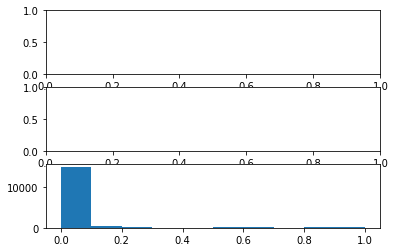

In [172]:
fig, ax = plt.subplots(nrows=3)
#ax[0].hist(y_val, bins=10)
#ax[1].hist(y_hat, bins=10)
ax[2].hist(predictions, bins=10)

In [173]:
submission['Square_ID'] = Id
submission['target_2019'] = predictions
#submission.to_csv(f'./submissions/sub_rf_{np.round(np.mean(scores), 4)}.csv', index=False)
submission.to_csv(f'./submissions/sub_catboost_{np.round(np.mean(score), 4)}.csv', index=False)
#submission.to_csv(f'./submissions/sub_nn_{np.round(np.mean(scores))}.csv', index=False)

#LB:0.0843 (md5, rs42, 4-fold-kf, no precip features)

In [174]:
submission.min(), submission.max()

(Square_ID      4e3c3896-14ce-11ea-bce5-f49634744a41
 target_2019                                       0
 dtype: object, Square_ID      4e6f5e01-14ce-11ea-bce5-f49634744a41
 target_2019                                       1
 dtype: object)